In this notebook, we'll create a framework for image classification in Tensorflow.

This code should be replicable to any image task with a few changes.

Our specific task will be to classify images of traffic lights as red, yellow, or green.


In [1]:
import sys
import os
import time
import itertools
import math
import random
import glob
import tensorflow as tf
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

First, we set some basic parameters:

    base_image_path: the path where our training data is stored
    
    image_types: subdirectories in the images folder, each one representing a different class
    
    input_img_x/y: width and height of the images
    
    train_test_split_ratio: the ratio of training images to testing images
    
    batch_size: the minibatch size
    
    checkpoint_name: where we will save our best model
    

In [2]:
# Basic parameters

base_image_path = "traffic_light_images/"
image_types = ["red", "green", "yellow"]
input_img_x = 32
input_img_y = 32
train_test_split_ratio = 0.9
learning_rate = 0.0001
max_epochs = 100
batch_size = 128
checkpoint_name = "model"
print('Basic parameters initialized')

Basic parameters initialized


We need to load in our images.  We do so using OpenCV's imread function.  After loading in each image, we resize it to our input size.

With each loaded image, we also specify the expected output.  For this, we use a one-hot encoding, creating an array of zeros represnting each class, and setting the index of the expected class number to 1.

For example, if we have three classes, and we expect an order of: [red neuron, green neuron, yellow neuron]

We initialize an array to [0, 0, 0] and if we loaded a yellow light, we change the last value to 1: [0, 0, 1]

Finally, we shuffle our dataset.  (It's generally useful to seed our random generator with 0 at the start of the program)

In [3]:
time_start = time.time()

v_loss = least_loss = 99999999

# Load data

full_set = []

for im_type in image_types:
    for ex in glob.glob(os.path.join(base_image_path, im_type, "*")):
        im = cv2.imread(ex)
        if not im is None:
            im = cv2.resize(im, (32, 32))

            # Create an array representing our classes and set it
            one_hot_y = [0] * len(image_types)
            one_hot_y[image_types.index(im_type)] = 1
            assert(im.shape == (32, 32, 3))

            full_set.append((im, one_hot_y, ex))

random.shuffle(full_set)
print(len(full_set))


1484


Using our train_test_split_ratio we create two lists of examples: testing and training.

In [4]:
# We split our data into a training and test set here

split_index = int(math.floor(len(full_set) * train_test_split_ratio))
train_set = full_set[:split_index]
test_set = full_set[split_index:]

# We ensure that our training and test sets are a multiple of batch size
train_set_offset = len(train_set) % batch_size
test_set_offset = len(test_set) % batch_size
train_set = train_set[: len(train_set) - train_set_offset]
test_set = test_set[: len(test_set) - test_set_offset]

X_train, y_train, train_z = zip(*train_set)
X_test, y_test, test_z = zip(*test_set)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                            test_size=0.20, random_state=42)

print(len(X_train))
print(len(X_valid))
print(len(X_test))

1024
256
128


In [5]:
# Helper layer functions
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
print('done')

done


Here we initialize our input and output neurons.

Our input neurons will be the shape of the image which is (32 x 32 x 3)

Because our data will be one-hot encoded, we have as many output neurons as we have classes

In [6]:
# Model

x = tf.placeholder(tf.float32, shape=[None, input_img_x, input_img_y, 3])
y_ = tf.placeholder(tf.float32, shape=[None, len(image_types)])
keep_prob = tf.placeholder(tf.float32) # probability to keep units

This is where we specify our first convolutional layers.

We specify the number of weights in the first line:

    W_conv1 = weight_variable([3, 3, 3, 16])
    
This line is for specifying the number of bias variables, or the variables that will be added to weights after multiplying them by the activation.

    b_conv1 = bias_variable([16])
    
Next, we specify the activation:

    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 1) + b_conv1)

In [7]:
x_image = x

# Our first three convolutional layers, of 16 3x3 filters
W_conv1 = weight_variable([3, 3, 3, 16])
b_conv1 = bias_variable([16])
h_conv1 = tf.nn.relu(tf.nn.bias_add(conv2d(x_image, W_conv1, 1), b_conv1))

W_conv2 = weight_variable([3, 3, 16, 16])
b_conv2 = bias_variable([16])
h_conv2 = tf.nn.relu(tf.nn.bias_add(conv2d(h_conv1, W_conv2, 1), b_conv2))

W_conv3 = weight_variable([3, 3, 16, 16])
b_conv3 = bias_variable([16])
h_conv3 = tf.nn.relu(tf.nn.bias_add(conv2d(h_conv2, W_conv3, 1), b_conv3))

# Our pooling layer
h_pool4 = max_pool_2x2(h_conv3)
n1, n2, n3, n4 = h_pool4.get_shape().as_list()

# We flatten our pool layer into a fully connected layer
h_pool4_flat = tf.reshape(h_pool4, [-1, n2*n3*n4])

W_fc1 = weight_variable([n2*n3*n4, 3])
b_fc1 = bias_variable([3])
logits = tf.nn.bias_add(tf.matmul(h_pool4_flat, W_fc1), b_fc1)
print('done')

done


Our loss function is defined as computing softmax, and then cross entropy.

We also specify our optimizer, which takes a learning rate, and a loss function.

Finally, we initialize all of our variables which will tell us if our model is valid.

In [8]:
# Our loss function and optimizer

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_, logits = logits))
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



Every time we iterate over all of our training examples, we have completed one epoch.  Generally, we should start with one epoch while debugging, and in practice many datasets will converge with less than 100 epochs.  It's something that needs to be explored with each dataset.

We split our training set into batches, which we train on in order.

We then use our entire datset to calculate training and validation loss.  These are the values we want to minimize, but it's important to pay attention to the interaction between them.  If training loss is going down, but validation is staying the same, it means we are overfitting our dataset: our network is becoming increasingly good at correctly classifying our training examples, but our network isn't generalizing to other examples outside the training set.

We save our model if the current model has the lowest validation seen in this training run.

Starting training... [1024 training examples]
Epoch     1: loss:   45.8199310303, val.loss:   48.5383224487, saving new best model to model
Epoch     2: loss:   36.9157981873, val.loss:   36.0543518066, saving new best model to model
Epoch     3: loss:   29.9068717957, val.loss:   30.4468669891, saving new best model to model
Epoch     4: loss:   22.4238300323, val.loss:   21.4654808044, saving new best model to model
Epoch     5: loss:   17.6990509033, val.loss:   17.2492523193, saving new best model to model
Epoch     6: loss:   13.7940111160, val.loss:   13.0003271103, saving new best model to model
Epoch     7: loss:   10.8401107788, val.loss:    9.9628143311, saving new best model to model
Epoch     8: loss:    8.6153783798, val.loss:    8.0143299103, saving new best model to model
Epoch     9: loss:    6.8305730820, val.loss:    6.2092900276, saving new best model to model
Epoch    10: loss:    5.4917125702, val.loss:    4.9666175842, saving new best model to model
Epoch    11: l

Epoch    95: loss:    0.0272780061, val.loss:    0.5243970156 
Epoch    96: loss:    0.0261197872, val.loss:    0.5316325426 
Epoch    97: loss:    0.0252990089, val.loss:    0.5259259343 
Epoch    98: loss:    0.0244238190, val.loss:    0.5329711437 
Epoch    99: loss:    0.0235489979, val.loss:    0.5309982896 
Epoch   100: loss:    0.0228328966, val.loss:    0.5351054072 


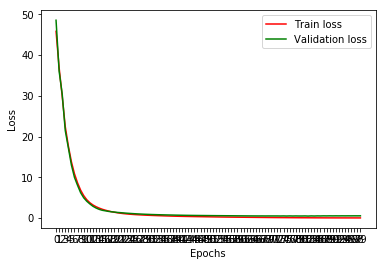

In [9]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
v_loss = 9999999
train_loss = []
val_loss = []

print("Starting training... [{} training examples]".format(len(X_train)))

for i in range(0, max_epochs):

    # Iterate over our training set
    for batch_i in range(0, int((len(X_train) / batch_size))):
        start_batch = batch_size * batch_i
        end_batch = batch_size * (batch_i + 1)
        train_step.run(feed_dict={x: X_train[start_batch:end_batch], y_: y_train[start_batch:end_batch]})
        ex_seen = "Current epoch{:5} examples seen: {:20} / {} \r".format(i+1, batch_i * batch_size, len(X_train))
        sys.stdout.write(ex_seen.format(batch_i * batch_size))
        sys.stdout.flush()

    ex_seen = "Current epoch{:5} examples seen: {:20} / {} \r".format(i+1, (batch_i + 1) * batch_size, len(X_train))
    sys.stdout.write(ex_seen.format(batch_i * batch_size))
    sys.stdout.flush()

    t_loss = loss.eval(feed_dict={x: X_train, y_: y_train})
    v_loss = loss.eval(feed_dict={x: X_valid, y_: y_valid})
    ,
    train_loss.append(t_loss)
    val_loss.append(v_loss)

    sys.stdout.write("Epoch {:5}: loss: {:15.10f}, val.loss: {:15.10f}".format(i + 1, t_loss, v_loss))

    if v_loss < least_loss:
        sys.stdout.write(", saving new best model to {}".format(checkpoint_name))
        least_loss = v_loss
        filename = saver.save(sess, "deepcars/model")

    sys.stdout.write("\n")

plt.figure()
plt.xticks(np.arange(0, len(train_loss), 1.0))
plt.ylabel("Loss")
plt.xlabel("Epochs")
train_line = plt.plot(range(0, len(train_loss)), train_loss, 'r', label="Train loss")
val_line = plt.plot(range(0, len(val_loss)), val_loss, 'g', label="Validation loss")
plt.legend()
plt.show()

Let's print the examples from our test set that were wrong:

Actual: red, predicted: yellow


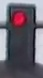

Actual: green, predicted: yellow


Actual: green, predicted: red


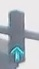

Actual: red, predicted: green


Actual: green, predicted: yellow


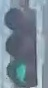

Actual: green, predicted: red


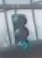

In [10]:
zipped_x_y = zip(X_test, y_test)
conf_true = []
conf_pred = []
for i in range(0, len(X_test)):
    sfmax = list(sess.run(tf.nn.softmax(logits.eval(feed_dict={x: [X_test[i]]})))[0])
    sf_ind = sfmax.index(max(sfmax))
    
    predicted_label = image_types[sf_ind]
    actual_label = image_types[y_test[i].index(max(y_test[i]))]
    
    conf_true.append(actual_label)
    conf_pred.append(predicted_label)
    
    if predicted_label != actual_label:
        print("Actual: {}, predicted: {}".format(actual_label, predicted_label))
        img_path = test_z[i]    
        ex_img = Image(filename=img_path)
        display(ex_img)

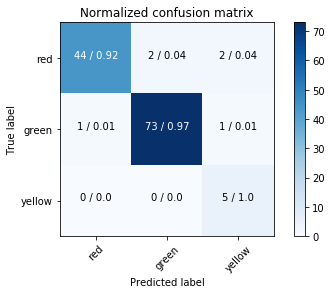

In [11]:
# From sklearn docs
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    cm2 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cm2 = np.around(cm2, 2)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(cm[i, j]) + " / " + str(cm2[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(conf_true, conf_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=image_types, normalize=False,
                      title='Normalized confusion matrix')
plt.show()